About the data:

The data contains contains data on Major League Baseball (MLB) games from the 2016 season.

Today, MLB is composed of 30 teams: 29 in the United States and one in Canada. Teams play 162 games each season and five teams in each league advance to a four-round postseason tournament that culminates in the World Series, a best-of-seven championship series between the two league champions that dates to 1903. Baseball broadcasts are aired on television, radio, and the Internet throughout North America and in several other countries throughout the world. MLB has the highest season attendance of any sports league in the world with more than 73 million spectators in 2015.

In [12]:
import kagglehub
import pandas as pd
import numpy as np

path = kagglehub.dataset_download("cyaris/2016-mlb-season")

print(path)

import os

data_path = os.path.join(path, 'baseball_reference_2016_clean.csv')

# Load the data into a pandas DataFrame
df = pd.read_csv(data_path)

print(df.head())  # Display the first few rows of the DataFrame

/root/.cache/kagglehub/datasets/cyaris/2016-mlb-season/versions/2
   Unnamed: 0  attendance              away_team  away_team_errors  \
0           0     40030.0          New York Mets                 1   
1           1     21621.0  Philadelphia Phillies                 0   
2           2     12622.0        Minnesota Twins                 0   
3           3     18531.0   Washington Nationals                 0   
4           4     18572.0       Colorado Rockies                 1   

   away_team_hits  away_team_runs        date field_type   game_type  \
0               7               3  2016-04-03   on grass  Night Game   
1               5               2  2016-04-06   on grass  Night Game   
2               5               2  2016-04-06   on grass  Night Game   
3               8               3  2016-04-06   on grass  Night Game   
4               8               4  2016-04-06   on grass    Day Game   

              home_team  ...  temperature  wind_speed         wind_direction  \


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2463 non-null   int64  
 1   attendance         2460 non-null   float64
 2   away_team          2463 non-null   object 
 3   away_team_errors   2463 non-null   int64  
 4   away_team_hits     2463 non-null   int64  
 5   away_team_runs     2463 non-null   int64  
 6   date               2463 non-null   object 
 7   field_type         2463 non-null   object 
 8   game_type          2463 non-null   object 
 9   home_team          2463 non-null   object 
 10  home_team_errors   2463 non-null   int64  
 11  home_team_hits     2463 non-null   int64  
 12  home_team_runs     2463 non-null   int64  
 13  start_time         2463 non-null   object 
 14  venue              2463 non-null   object 
 15  day_of_week        2463 non-null   object 
 16  temperature        2463 

The data has no null values and looks clean. Now I ould like t to fit a linear regression to predict attendance using the following predictors:

*   'game_type' — is the game during the day or at night?
*   'day_of_week' — what day of the week did the game occur?
*   'temperature' — average game temperature (Fahrenheit).
*   'sky' — description of sky condition at the time of the game.
*   'total_runs' — total runs scored in the game.
*   'field_type' - is the game on grass or on turf?

# **Preview of the dataset**

In [18]:
df_reg = df[['attendance', 'game_type', 'day_of_week', 'temperature', 'sky', 'total_runs', 'field_type']]
df_reg.head()

,attendance,game_type,day_of_week,temperature,sky,total_runs,field_type
0,40030.0,Night Game,Sunday,74.0,Sunny,7,on grass
1,21621.0,Night Game,Wednesday,55.0,Overcast,5,on grass
2,12622.0,Night Game,Wednesday,48.0,Unknown,6,on grass
3,18531.0,Night Game,Wednesday,65.0,Cloudy,4,on grass
4,18572.0,Day Game,Wednesday,77.0,In Dome,7,on grass


In [19]:
df_reg.dtypes

,0
attendance,float64
game_type,object
day_of_week,object
temperature,float64
sky,object
total_runs,int64
field_type,object


Based on the above results, columns such as attendance, temperature, and total runs are numerical data while game_types, day of the week, sky, and field type are categorical. Now let's check how categorical data is coded

In [22]:
categorical_columns = ['game_type', 'day_of_week', 'sky', 'field_type']

for column in categorical_columns:
    print(f"Unique values in column '{column}':")
    print(df_reg[column].unique())



Unique values in column 'game_type':
['Night Game' 'Day Game']
Unique values in column 'day_of_week':
['Sunday' 'Wednesday' 'Tuesday' 'Monday' 'Thursday' 'Saturday' 'Friday']
Unique values in column 'sky':
['Sunny' 'Overcast' 'Unknown' 'Cloudy' 'In Dome' 'Drizzle' 'Rain' 'Night']
Unique values in column 'field_type':
['on grass' 'on turf']


The observations with missing values are sometimes expressed as 'Nan' or 'Unknown' which is stored in the column 'sky'. It will either have to be removed or replaced (with an imputed value or missing data type that Python can recognize, such as np.NaN) to proceed with fitting a regression model

In [38]:
df_reg['sky'].value_counts()

,count
sky,
Cloudy,759
Sunny,744
Unknown,402
In Dome,356
Overcast,159
Drizzle,16
Rain,12
Night,12


We see that 402 values are unknown. Since we have 2460 observations, removing 402 which is almost 25% of the data will affect our predictions. Therefore, it is maybe better to remove the column 'sky'

Furthermore, we can go deeper to make a boxplot for each categorical variable corresponding attendance

In [39]:
# prompt: remove the column sky

df_reg = df_reg.drop('sky', axis=1)


<ipython-input-44-67494e3a47ca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y='attendance', data=df_reg, palette = 'Set2')


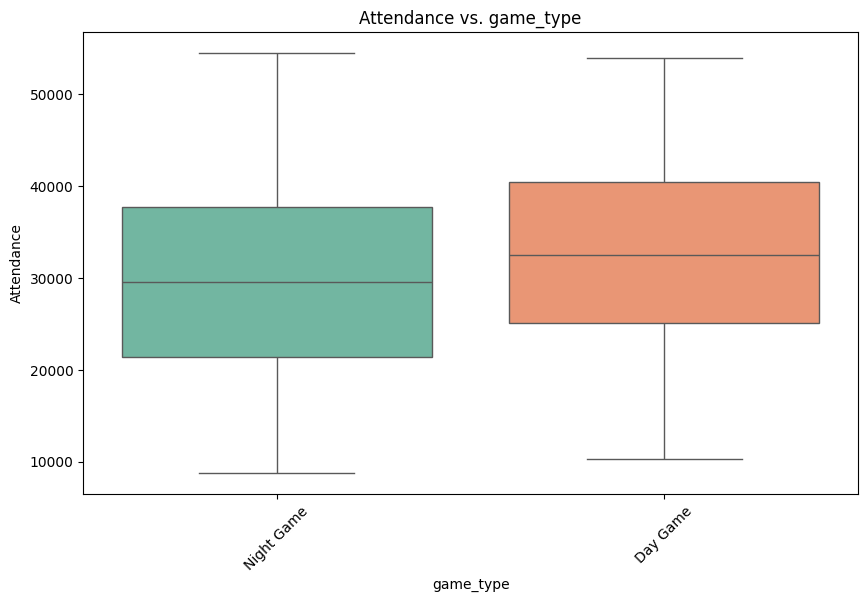

<ipython-input-44-67494e3a47ca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y='attendance', data=df_reg, palette = 'Set2')


<Figure size 640x480 with 0 Axes>

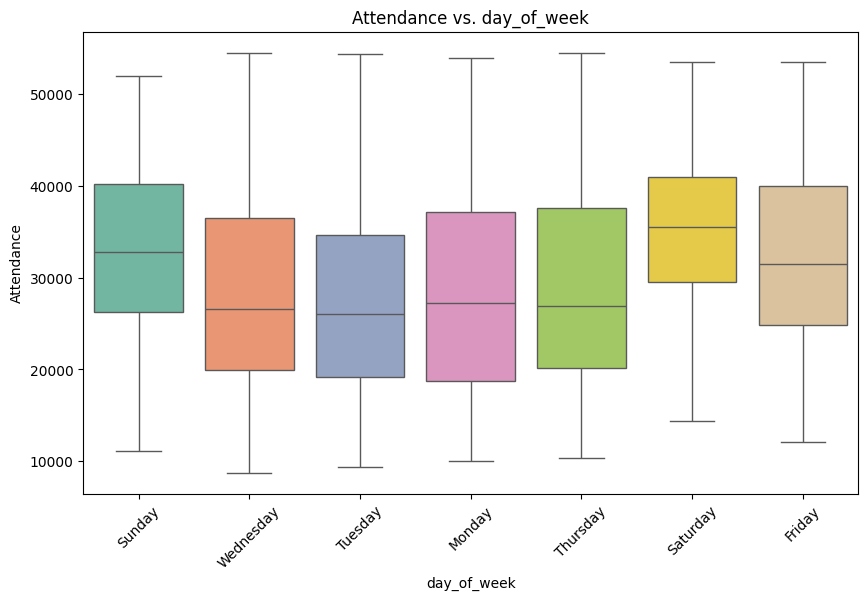

<ipython-input-44-67494e3a47ca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y='attendance', data=df_reg, palette = 'Set2')


<Figure size 640x480 with 0 Axes>

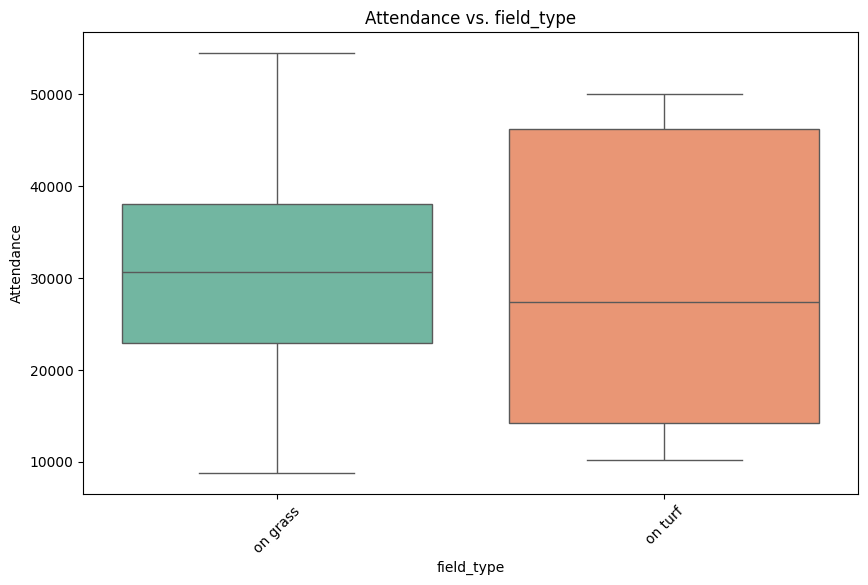

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_columns = ['game_type', 'day_of_week', 'field_type']
# Loop through categorical columns and create boxplots
for column in categorical_columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.boxplot(x=column, y='attendance', data=df_reg, palette = 'Set2')
    plt.title(f'Attendance vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Attendance')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    plt.clf()


Game Type:

Day games tend to have slightly higher attendance while night games have wider distribution suggesting more variability in attendance.

Day of Week:

Attendance is relatively consistent across the week but slightly lower on Tuesdays and Wednesdays.
Weekends, especially Saturdays, show a wider distribution of attendance.

Field Type:

On grass fields, median attendance is slightly higher.
On turf fields, there's a smaller interquartile range, indicating less variability in attendance.

Let's further discover the associations between these categorical variables and attendance. To do so, we need to run ttest or ANOVA & Tukey range

Since the t-test assumes that the data is normally distributed and has equal variances, let's check the distribution of these variables

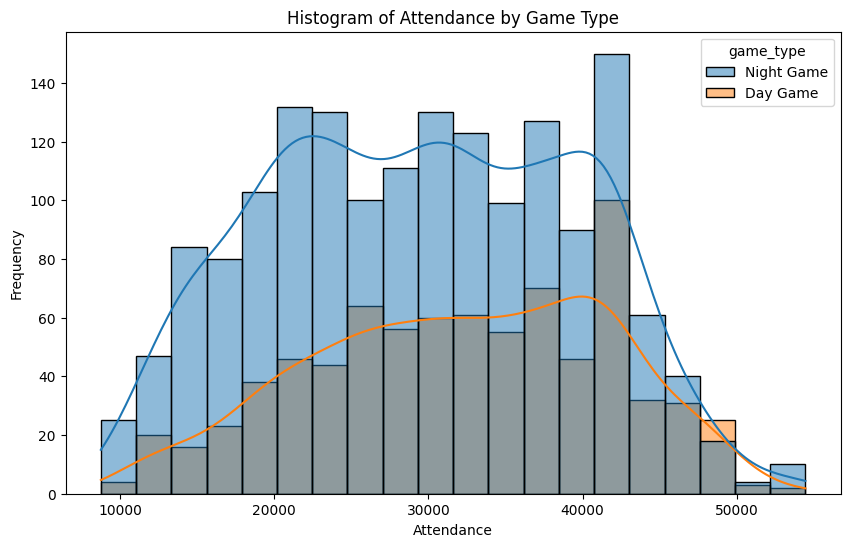

In [41]:
# Create a histogram of attendance for each game type
plt.figure(figsize=(10, 6))
sns.histplot(data=df_reg, x='attendance', hue='game_type', kde=True)
plt.title('Histogram of Attendance by Game Type')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.show()


The 'game_type' variable is not normally distributed. A normal distribution is characterized by a bell-shaped curve with a single peak. In this case, the bimodal distribution indicates two distinct groups, which is expected for a categorical variable with two levels (Day/Night). Therefore, our analysis might get biased. The t-test assumes that the data is approximately normally distributed within each group.
Bimodal data has two peaks, which means it's not normally distributed, and this can affect the validity of the t-test results.

Instead, we can run Permutation test which involves resampling the data many times to test the difference between the two groups.

In [42]:
from scipy.stats import permutation_test

binary_columns = ['game_type', 'field_type']

for column in binary_columns:
  # Create two groups based on the binary column
  group1_attendance = df_reg.loc[df_reg[column] == df_reg[column].unique()[0], 'attendance']
  group2_attendance = df_reg.loc[df_reg[column] == df_reg[column].unique()[1], 'attendance']

  # Perform a permutation test
  def permutation_statistic(x, y):
    return np.mean(x) - np.mean(y)

  result = permutation_test((group1_attendance, group2_attendance),
                            statistic=permutation_statistic,
                            permutation_type='independent',
                            n_resamples=10000)

  print(f"Permutation test for {column}:")
  print(f"  p-value: {result.pvalue}")
  print(f"  statistic: {result.statistic}")

  # Interpret the results
  if result.pvalue < 0.05:
    print(f"  There is a statistically significant difference in attendance between {df_reg[column].unique()[0]} and {df_reg[column].unique()[1]}")
  else:
    print(f"  There is no statistically significant difference in attendance between {df_reg[column].unique()[0]} and {df_reg[column].unique()[1]}")


Permutation test for game_type:
  p-value: 0.00019998000199980003
  statistic: -2567.9780392346365
  There is a statistically significant difference in attendance between Night Game and Day Game
Permutation test for field_type:
  p-value: 0.23197680231976803
  statistic: 942.4686875703446
  There is no statistically significant difference in attendance between on grass and on turf


Based on the p-value of each variable, we make the following analysis:

game_type: The p-value (0.000) is less than the significance level of 0.05, indicating a statistically significant difference in attendance between day and night games. This suggests that the type of game (day or night) has a significant impact on attendance.


field_type: The p-value (0.231) is greater than the significance level of 0.05, suggesting that there is no statistically significant difference in attendance between games played on grass and turf fields. This implies that the type of field might not have a major influence on attendance.

# **Scaling**

In [43]:
df_reg.describe()

,attendance,temperature,total_runs
count,2460.000000,2460.000000,2460.000000
mean,30370.703659,73.812602,8.935366
std,9875.466703,10.581749,4.480527
min,8766.000000,31.000000,1.000000
25%,22432.000000,67.000000,6.000000
50%,30604.500000,74.000000,8.000000
75%,38396.250000,81.000000,12.000000
max,54449.000000,101.000000,29.000000


Two features - temperature and total_runs - are on different scales because what they are measuring are different (temperature is in degrees Fahrenheit, total_runs is the number of runs scored in a game). Because of this, the ranges of values and the standard deviations for each are very different from one another. We can see here that temperature has a standard deviation of about 10.58, while total_runs has a standard deviation of about 4.48.


When working with features with largely differing scales, it is often a good idea to standardize the features so that they all have a mean of 0 and a standard deviation of 1.

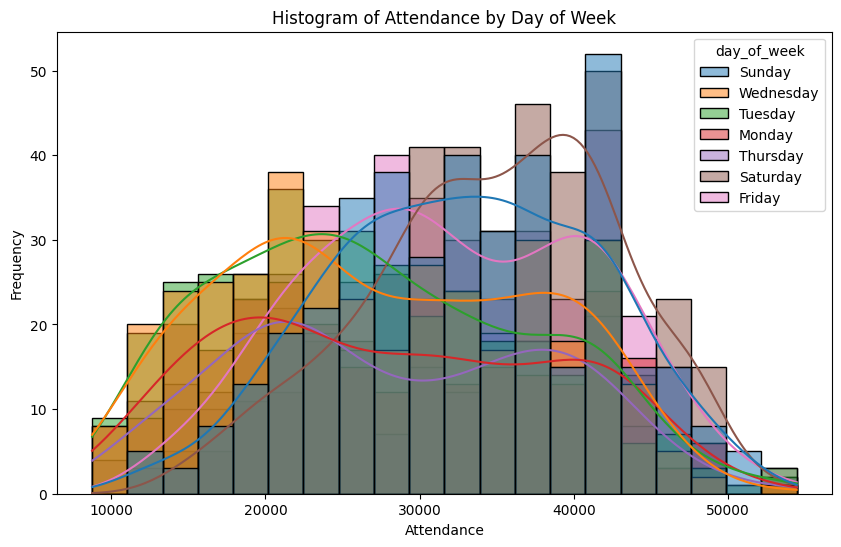

Shapiro-Wilk test for Sunday:
  Statistic: 0.989520408850998
  P-value: 0.006647942478417858
  Attendance on Sunday does not appear to be normally distributed.
Shapiro-Wilk test for Wednesday:
  Statistic: 0.9665926035200321
  P-value: 1.2887547451464363e-07
  Attendance on Wednesday does not appear to be normally distributed.
Shapiro-Wilk test for Tuesday:
  Statistic: 0.9704026950408509
  P-value: 6.711181489972213e-07
  Attendance on Tuesday does not appear to be normally distributed.
Shapiro-Wilk test for Monday:
  Statistic: 0.9601727314798875
  P-value: 6.658336928617276e-07
  Attendance on Monday does not appear to be normally distributed.
Shapiro-Wilk test for Thursday:
  Statistic: 0.964441488333445
  P-value: 7.855373579753587e-06
  Attendance on Thursday does not appear to be normally distributed.
Shapiro-Wilk test for Saturday:
  Statistic: 0.9834469102042305
  P-value: 0.00016804485965742487
  Attendance on Saturday does not appear to be normally distributed.
Shapiro-Wilk 

In [45]:
from scipy.stats import shapiro

# Create a histogram of attendance for each day of the week
plt.figure(figsize=(10, 6))
sns.histplot(data=df_reg, x='attendance', hue='day_of_week', kde=True)
plt.title('Histogram of Attendance by Day of Week')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.show()

# Perform Shapiro-Wilk test for normality
for day in df_reg['day_of_week'].unique():
  attendance_day = df_reg.loc[df_reg['day_of_week'] == day, 'attendance']
  statistic, p_value = shapiro(attendance_day)
  print(f"Shapiro-Wilk test for {day}:")
  print(f"  Statistic: {statistic}")
  print(f"  P-value: {p_value}")

  if p_value > 0.05:
    print(f"  Attendance on {day} appears to be normally distributed.")
  else:
    print(f"  Attendance on {day} does not appear to be normally distributed.")


Because the attendance of each day of the week is not normally distributed we cannot run ANOVA and Tukey's Range tests. However, we can use Spearman’s rank correlation. This method evaluates how well the relationship between two variables can be described by a monotonic function, without assuming normality.

In [46]:
from scipy.stats import spearmanr

# Calculate Spearman's rank correlation between day_of_week and attendance
correlation, p_value = spearmanr(df_reg['day_of_week'], df_reg['attendance'])

print(f"Spearman's rank correlation between day_of_week and attendance:")
print(f"  Correlation coefficient: {correlation}")
print(f"  P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant monotonic relationship between day_of_week and attendance.")
else:
    print("There is no statistically significant monotonic relationship between day_of_week and attendance.")


Spearman's rank correlation between day_of_week and attendance:
  Correlation coefficient: -0.16661186924245486
  P-value: 8.970174549284502e-17
There is a statistically significant monotonic relationship between day_of_week and attendance.


The result indicated a statistically significant difference in attendance across days of the week. This suggests that a particular weekday might have a significant impact on attendance.

# **Distributions and Associations**

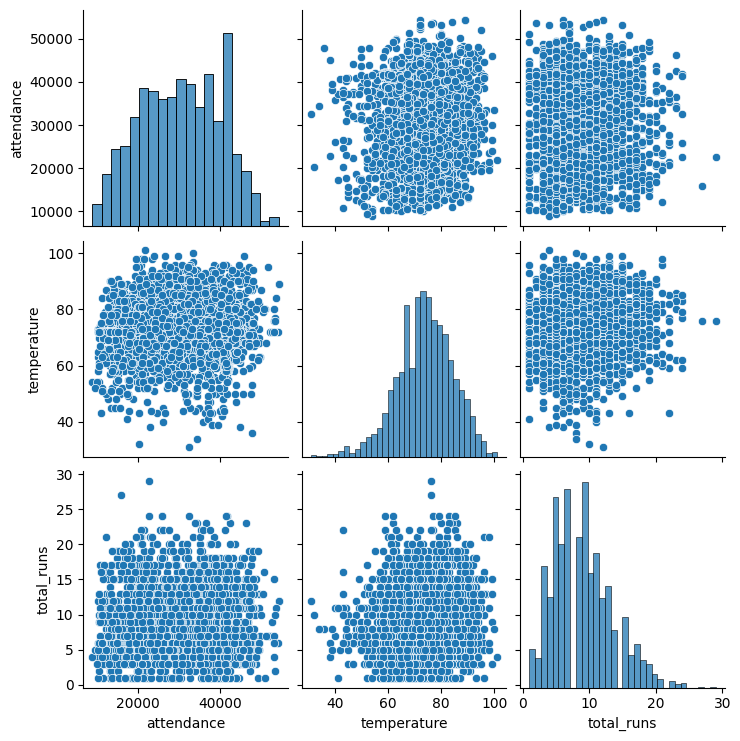

In [47]:
sns.pairplot(df_reg)
plt.show()


Looking at the histograms along the diagonal, total_runs seems to be somewhat right-skewed. This indicates that we may want to transform this feature to make it more normally distributed.

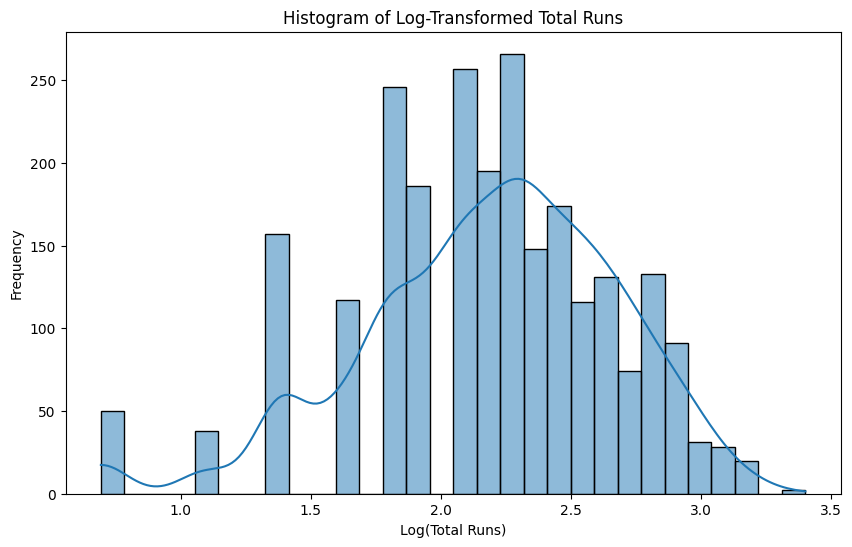

In [48]:
# Apply a log transformation to 'total_runs'
df_reg['total_runs_log'] = np.log1p(df_reg['total_runs'])

# Visualize the transformed variable
plt.figure(figsize=(10, 6))
sns.histplot(df_reg['total_runs_log'], kde=True)
plt.title('Histogram of Log-Transformed Total Runs')
plt.xlabel('Log(Total Runs)')
plt.ylabel('Frequency')
plt.show()


In [54]:
from sklearn.preprocessing import StandardScaler

# Select the features to standardize
features_to_standardize = ['attendance', 'temperature', 'total_runs']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected features
df_reg[features_to_standardize] = scaler.fit_transform(df_reg[features_to_standardize])

# Print the standardized DataFrame
print(df_reg.head())


   attendance   game_type day_of_week  temperature  total_runs field_type  \
0    0.978309  Night Game      Sunday     0.017713   -0.432038   on grass   
1   -0.886184  Night Game   Wednesday    -1.778196   -0.878505   on grass   
2   -1.797618  Night Game   Wednesday    -2.439847   -0.655272   on grass   
3   -1.199144  Night Game   Wednesday    -0.832981   -1.101739   on grass   
4   -1.194992    Day Game   Wednesday     0.301278   -0.432038   on grass   

   total_runs_log  
0        2.079442  
1        1.791759  
2        1.945910  
3        1.609438  
4        2.079442  


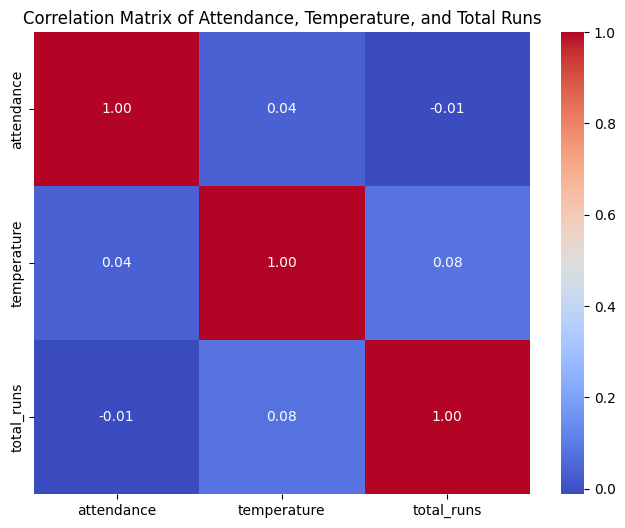

In [58]:
# Select the features for the heatmap
heatmap_features = ['attendance', 'temperature', 'total_runs']

# Create a correlation matrix
correlation_matrix = df_reg[heatmap_features].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attendance, Temperature, and Total Runs')
plt.show()

There is very weak correlation across features

***Summary***

Factors Influencing Attendance:

Game Type: There's a statistically significant difference in attendance between day and night games, with day games generally having higher attendance.


Day of Week: Attendance varies significantly across the days of the week, with certain weekdays potentially having a greater impact on attendance. Tuesdays and Wednesdays tend to have lower attendance.

Field Type: There's no statistically significant difference in attendance between games played on grass and turf fields, suggesting that field type might not be a major factor.

Temperature and Total Runs: These numerical features have a very weak correlation with attendance.